In [1]:
import os
import pandas as pd


main_publisher = 'Merged'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_precedences = pd.read_csv(path + 'precedences_all.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_precedences.isna().sum().sum():04d} Nan values in precedence links.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0000 Nan values in precedence links.


In [2]:
def id_mapper(df_col, name):
    unique_id = df_col.unique()
    return pd.DataFrame({
            name : unique_id,
            'mappedID' : pd.RangeIndex(len(unique_id))
        })


unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')

In [3]:
import torch 

def edge_construction(df1, df2, col, how, right_on, left_on = None):
    if left_on == None:
        left_on = right_on
    links = pd.merge(df1, df2, right_on = right_on, left_on = left_on, how = how)
    links = torch.from_numpy(links[col].values)
    return links

oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_attr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')
oer_before_oer_subject = edge_construction(df1 = df_precedences, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_object = edge_construction(df1 = df_precedences, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0)
oer_before_oer = torch.stack([oer_before_oer_subject, oer_before_oer_object], dim = 0)

print(oer_covers_concept)
print(oer_before_oer)

tensor([[   0,    1,    1,  ..., 4406, 4406, 4406],
        [   0,    1,    2,  ...,  875, 7969,  266]])
tensor([[   0,    0,    0,  ..., 4404, 4404, 4405],
        [   1,    2,    3,  ..., 4405, 4406, 4406]])


In [6]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
#data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
#data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
#data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_attr
data['OER', 'before', 'OER'].edge_index = oer_before_oer
#data = T.ToUndirected()(data)
data

/home/abazouzi/Documents/Code/PrerequisiteLearning/clara-datasets/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HeteroData(
  OER={ node_id=[4407] },
  (OER, before, OER)={ edge_index=[2, 212433] }
)

In [7]:
transform = T.RandomLinkSplit(
    num_val = 0.2,
    num_test = 0.2,
    #disjoint_train_ratio=0.5,
    #neg_sampling_ratio = 1.0,
    add_negative_train_samples = True,
    edge_types=('OER', 'before', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before", "OER"].edge_label.detach().numpy())}\t Edges for testing')

254922	 Edges for training
84972	 Edges for validation
84972	 Edges for testing


In [8]:
from torch_geometric.nn import GCNConv, SAGEConv, Linear, to_hetero
import torch.nn.functional as F
from torch import Tensor

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(hidden_channels, hidden_channels, add_self_loops = False, cached = True)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = False, cached = True)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x : Tensor, edge_index : Tensor):
        x = self.sigmoid(self.conv1(x, edge_index))
        x = self.sigmoid(self.conv2(x, edge_index))
        return x
    
class Classifier(torch.nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.linear = Linear(input_channels, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x : Tensor, edge_label_index : Tensor) -> Tensor:
        edge_feat_oer_before = x[edge_label_index[0]]
        edge_feat_oer_after = x[edge_label_index[1]]
        edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
        prod = self.linear(edge_vec)
        #prod = self.sigmoid(prod)
        #prod = (edge_feat_oer_before * edge_feat_oer_after).mean(dim = -1)
        #prod = F.softmax(prod, dim = 1)
        #prod = prod.sum(dim = -1) < 0.5) * 1.0
        return torch.squeeze(prod)
    
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.oer_emb = torch.nn.Embedding(data["OER"].num_nodes, hidden_channels)
        self.oer_lin = torch.nn.Linear(20, hidden_channels)
        #print("OER EMBEDDING ", self.oer_emb.weight.data.numpy()[1])
        #self.concept_emb = torch.nn.Embedding(data["Concept"].num_nodes, hidden_channels)
        self.gnn = GNN(hidden_channels)
        self.gnn = to_hetero(self.gnn, metadata = data.metadata())
        self.classifier = Classifier(hidden_channels * 2)

    def forward(self, data : HeteroData) -> Tensor:
        x_dict = {
            #"Concept" : self.concept_emb(data["Concept"].node_id),
            #"OER" : torch.cat((self.oer_lin(data["OER"].node_id), oer_emb(data["OER"].node_id)), dim = 0),
            "OER" : self.oer_emb(data["OER"].node_id)
        }
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["OER"],
            data["OER", "before", "OER"].edge_label_index
        )
        return pred
   
model = Model(hidden_channels = 128)

In [9]:
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
train_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
total_loss = 0
loss_values = []
for epoch in range(1,201):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data)
    ground_truth = train_data["OER", "before", "OER"].edge_label
    assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
    loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")

Epoch : 010, Loss :  6.9329
Epoch : 020, Loss :  13.6595
Epoch : 030, Loss :  20.2682
Epoch : 040, Loss :  26.7704
Epoch : 050, Loss :  33.1633
Epoch : 060, Loss :  39.4611
Epoch : 070, Loss :  45.6911
Epoch : 080, Loss :  51.8598
Epoch : 090, Loss :  57.9632
Epoch : 100, Loss :  63.9888
Epoch : 110, Loss :  69.9146
Epoch : 120, Loss :  75.7173
Epoch : 130, Loss :  81.3921
Epoch : 140, Loss :  86.9704
Epoch : 150, Loss :  92.4974
Epoch : 160, Loss :  97.9969
Epoch : 170, Loss :  103.4760
Epoch : 180, Loss :  108.9375
Epoch : 190, Loss :  114.3839
Epoch : 200, Loss :  119.8170


<function matplotlib.pyplot.show(close=None, block=None)>

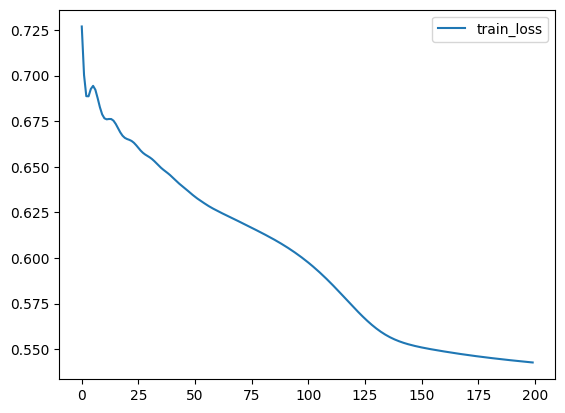

In [12]:
from matplotlib import pyplot as plt

plt.plot(loss_values, label='train_loss')
plt.legend()
plt.show

Validation AUC : 0.7881
Validation Precision : 0.7472
Validation Accuracy : 0.6831


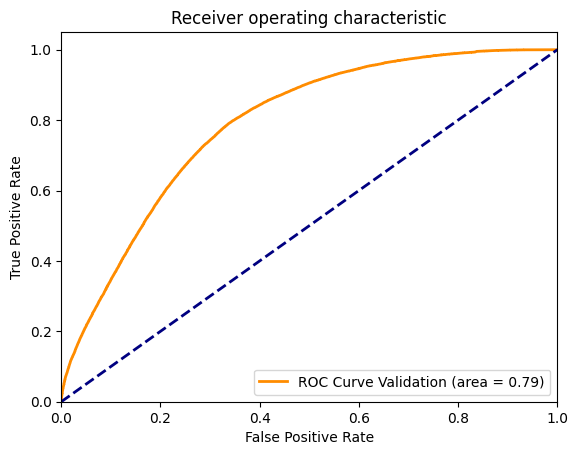

In [13]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, roc_curve, auc

preds = model(val_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = val_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"Validation AUC : {auc_score:.4f}")
precision = precision_score(ground_truths, preds_labels)
print(f"Validation Precision : {precision:.4f}")
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"Validation Accuracy : {accuracy:.4f}")
fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Validation (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

TEST AUC : 0.7849
TEST Precision : 0.7448
TEST Accuracy : 0.6810


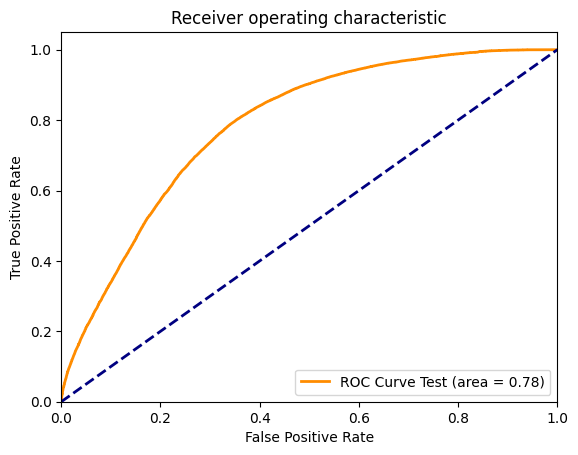

In [14]:
preds = model(test_data).detach().numpy()
preds_labels = (preds > 0.5) * 1
ground_truths = test_data["OER", "before", "OER"].edge_label.detach().numpy()
auc_score = roc_auc_score(ground_truths, preds)
print(f"TEST AUC : {auc_score:.4f}")
precision = precision_score(ground_truths, preds_labels)
print(f"TEST Precision : {precision:.4f}")
accuracy = accuracy_score(ground_truths, preds_labels)
print(f"TEST Accuracy : {accuracy:.4f}")
fpr, tpr, thresholds = roc_curve(ground_truths, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC Curve Test (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()